In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%cd /home/optima/mhaderer/AILS-MICCAI-UWF4DR-Challenge

[Errno 2] No such file or directory: '/home/optima/mhaderer/AILS-MICCAI-UWF4DR-Challenge'
/Users/moritz/Documents/Master/AILS-MICCAI-UWF4DR-Challenge/notebooks


/Users/moritz/miniconda3/envs/AILS-MICCAI-UWF4DR-Challenge/lib/python3.10/site-packages/IPython/core/magics/osm.py:393: UserWarning: This is now an optional IPython functionality, using bookmarks requires you to install the `pickleshare` library.
  bkms = self.shell.db.get('bookmarks', {})


In [3]:
# setup
#!apt-get update
#!pip install python-dotenv
#!pip install loguru
#!pip install gdown
#!pip install typer

In [4]:
# load data and unzip data

#!python tools/download_data_and_chkpts.py

In [5]:
# imports

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import wandb

from sklearn.metrics import roc_auc_score, average_precision_score

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import time

from ails_miccai_uwf4dr_challenge.models.metrics import sensitivity_score, specificity_score
from ails_miccai_uwf4dr_challenge.dataset import ChallengeTaskType, CustomDataset, DatasetBuilder, DatasetOriginationType
from ails_miccai_uwf4dr_challenge.preprocess_augmentations import ResidualGaussBlur, MultiplyMask
from ails_miccai_uwf4dr_challenge.models.trainer import DefaultMetricsEvaluationStrategy, Metric, MetricCalculatedHook, \
    NumBatches, Trainer, EpochTrainingStrategy, EpochValidationStrategy, DefaultEpochTrainingStrategy, \
    DefaultBatchTrainingStrategy, TrainingContext, PersistBestModelOnEpochEndHook
from ails_miccai_uwf4dr_challenge.models.architectures.task1_automorph_plain import AutoMorphModel
from ails_miccai_uwf4dr_challenge.models.architectures.task1_efficientnet_plain import Task1EfficientNetB4
from ails_miccai_uwf4dr_challenge.config import WANDB_API_KEY, PROJ_ROOT

wandb.login(key=WANDB_API_KEY)

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: moritsih (moritz-domain-generalization). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /Users/moritz/.netrc


True

In [6]:
# select device for training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device: " + str(device))

Device: cpu


In [27]:



preprocessing = A.Compose([
        A.Resize(800, 1016, p=1),
        A.Normalize(mean=[0.406, 0.485, 0.456], std=[0.225, 0.229, 0.224], p=1),
        #ResidualGaussBlur(p=1),
        MultiplyMask(p=1),
        A.Resize(800, 1016, p=1),
        #A.Equalize(p=0.1),
        #A.CLAHE(clip_limit=5., p=0.3)
    ])

augment_train = A.Compose([
        #A.VerticalFlip(p=0.5),
        #A.HorizontalFlip(p=0.5),
        #A.Affine(rotate=15, rotate_method='ellipse', p=0.5),
        ToTensorV2(p=1)
    ])

augment_val = A.Compose([
        ToTensorV2(p=1)
    ])


transforms_train = A.Compose([
    preprocessing,
    augment_train
])

transforms_val = A.Compose([
    preprocessing,
    augment_val
])

In [28]:
def train(config=None):

    wandb.init(project="task2", config=config)
    config = wandb.config

    dataset = DatasetBuilder(dataset=DatasetOriginationType.ORIGINAL, task=ChallengeTaskType.TASK2)
    train_data, val_data = dataset.get_train_val()

    train_dataset = CustomDataset(train_data, transform=transforms_train)
    val_dataset = CustomDataset(val_data, transform=transforms_val)

    train_loader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=config.batch_size, shuffle=False)
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu" if torch.backends.mps.is_available() else "cpu") #don't use mps, it takes ages, whyever that is the case!?!
    print(f"Using device: {device}")

    if 'AutoMorphModel' in config.model_type:
        model = AutoMorphModel(enc_frozen=True)
    elif 'Task1EfficientNetB4' in config.model_type:
        model = Task1EfficientNetB4()
    else:
        raise ValueError(f"Unknown model: {config['model_type']}")

    model.to(device)
    
    print("Training model: ", model.__class__.__name__)    

    metrics = [
        Metric('auroc', roc_auc_score),
        Metric('auprc', average_precision_score),
        Metric('accuracy', lambda y_true, y_pred: (y_pred.round() == y_true).mean()),
        Metric('sensitivity', sensitivity_score),
        Metric('specificity', specificity_score)
    ]

    class WandbLoggingHook(MetricCalculatedHook):
        def on_metric_calculated(self, training_context: TrainingContext, metric: Metric, result, last_metric_for_epoch: bool):
            import wandb
            wandb.log(data={metric.name: result}, commit=last_metric_for_epoch)

    metrics_eval_strategy = DefaultMetricsEvaluationStrategy(metrics).register_metric_calculated_hook(WandbLoggingHook())

    def combined_losses(pred, target):
        bce = F.binary_cross_entropy_with_logits(pred, target) * 0.5
        smooth_l1 = F.smooth_l1_loss(pred, target) * 0.5
        return bce + smooth_l1

    criterion = combined_losses
    optimizer = optim.AdamW(model.parameters(), lr=config["learning_rate"])
    lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

    trainer = Trainer(model, train_loader, val_loader, criterion, optimizer, lr_scheduler, device, 
                        metrics_eval_strategy=metrics_eval_strategy)

    # build a file name for the model weights containing current timestamp and the model class
    training_timestamp = time.strftime("%Y-%m-%d_%H-%M-%S")
    persist_model_hook = PersistBestModelOnEpochEndHook(f"best_model_{training_timestamp}.pth")
    trainer.add_epoch_end_hook(persist_model_hook) # TODO uncomment this line to save the best model

    #print("First train 2 epochs 2 batches to check if everything works - you can comment these two lines after the code has stabilized...")
    #trainer.train(num_epochs=2, num_batches=NumBatches.TWO_FOR_INITIAL_TESTING)
    
    print("Now train train train")
    trainer.train(num_epochs=config.epochs)
    wandb.finish()
    print("Finished training")

In [29]:


config = {
    "dataset": "original",
    "task": "task2",
    "augmentations": "resize only",
    "loss_func": "combined losses",
    "learning_rate": 1e-3,
    "epochs": 50,
    "batch_size": 32,
    "model_type": "AutoMorphModel encoder unfrozen"
}

WANDB_HTTP_TIMEOUT=300
WANDB_INIT_TIMEOUT =600
WANDB_DEBUG=True


In [30]:
train(config)

Dataset length:  160
Dataset length:  41
Using device: cuda
Loaded pretrained weights for efficientnet-b4
Training model:  AutoMorphModel


/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Now train train train


Epoch 1/50 - Avg val Loss: 1.223708: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.11s/it]


New best model found at epoch 1 with validation loss: 1.2237. Model saved to best_model_2024-07-17_15-16-40.pth


Epoch 2/50 - Avg val Loss: 0.436552: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.13s/it]


New best model found at epoch 2 with validation loss: 0.4366. Model saved to best_model_2024-07-17_15-16-40.pth


Epoch 21/50 - Avg val Loss: 0.432003: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.07it/s]


New best model found at epoch 21 with validation loss: 0.4320. Model saved to best_model_2024-07-17_15-16-40.pth


Epoch 22/50 - Avg val Loss: 0.426954: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.01s/it]


New best model found at epoch 22 with validation loss: 0.4270. Model saved to best_model_2024-07-17_15-16-40.pth


Epoch 23/50 - Avg val Loss: 0.420727: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.08it/s]


New best model found at epoch 23 with validation loss: 0.4207. Model saved to best_model_2024-07-17_15-16-40.pth


Epoch 24/50 - Avg val Loss: 0.410696: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.11it/s]


New best model found at epoch 24 with validation loss: 0.4107. Model saved to best_model_2024-07-17_15-16-40.pth


Epoch 25/50 - Avg val Loss: 0.398777: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.03it/s]


New best model found at epoch 25 with validation loss: 0.3988. Model saved to best_model_2024-07-17_15-16-40.pth


Epoch 26/50 - Avg val Loss: 0.386024: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.05s/it]


New best model found at epoch 26 with validation loss: 0.3860. Model saved to best_model_2024-07-17_15-16-40.pth


Epoch 27/50 - Avg val Loss: 0.375766: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.07it/s]


New best model found at epoch 27 with validation loss: 0.3758. Model saved to best_model_2024-07-17_15-16-40.pth


Epoch 28/50 - Avg val Loss: 0.364061: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.08it/s]


New best model found at epoch 28 with validation loss: 0.3641. Model saved to best_model_2024-07-17_15-16-40.pth


Epoch 29/50 - Avg val Loss: 0.354802: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.10s/it]


New best model found at epoch 29 with validation loss: 0.3548. Model saved to best_model_2024-07-17_15-16-40.pth


Epoch 30/50 - Avg val Loss: 0.347973: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.01s/it]


New best model found at epoch 30 with validation loss: 0.3480. Model saved to best_model_2024-07-17_15-16-40.pth


Epoch 31/50 - Avg val Loss: 0.341223: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.03it/s]


New best model found at epoch 31 with validation loss: 0.3412. Model saved to best_model_2024-07-17_15-16-40.pth


Epoch 32/50 - Avg val Loss: 0.334007: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.08s/it]


New best model found at epoch 32 with validation loss: 0.3340. Model saved to best_model_2024-07-17_15-16-40.pth


Epoch 33/50 - Avg val Loss: 0.326117: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.09it/s]


New best model found at epoch 33 with validation loss: 0.3261. Model saved to best_model_2024-07-17_15-16-40.pth


Epoch 34/50 - Avg val Loss: 0.317953: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.03s/it]


New best model found at epoch 34 with validation loss: 0.3180. Model saved to best_model_2024-07-17_15-16-40.pth


Epoch 35/50 - Avg val Loss: 0.311425: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.03s/it]


New best model found at epoch 35 with validation loss: 0.3114. Model saved to best_model_2024-07-17_15-16-40.pth


Epoch 36/50 - Avg val Loss: 0.305401: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.09it/s]


New best model found at epoch 36 with validation loss: 0.3054. Model saved to best_model_2024-07-17_15-16-40.pth


Epoch 37/50 - Avg val Loss: 0.299811: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.12s/it]


New best model found at epoch 37 with validation loss: 0.2998. Model saved to best_model_2024-07-17_15-16-40.pth


Epoch 38/50 - Avg val Loss: 0.295338: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.03s/it]


New best model found at epoch 38 with validation loss: 0.2953. Model saved to best_model_2024-07-17_15-16-40.pth


Epoch 39/50 - Avg val Loss: 0.292190: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.05it/s]


New best model found at epoch 39 with validation loss: 0.2922. Model saved to best_model_2024-07-17_15-16-40.pth


Epoch 40/50 - Avg val Loss: 0.289209: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.14s/it]


New best model found at epoch 40 with validation loss: 0.2892. Model saved to best_model_2024-07-17_15-16-40.pth


Epoch 41/50 - Avg val Loss: 0.286177: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.09it/s]


New best model found at epoch 41 with validation loss: 0.2862. Model saved to best_model_2024-07-17_15-16-40.pth


Epoch 42/50 - Avg val Loss: 0.283549: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.02it/s]


New best model found at epoch 42 with validation loss: 0.2835. Model saved to best_model_2024-07-17_15-16-40.pth


Epoch 43/50 - Avg val Loss: 0.281383: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.11it/s]


New best model found at epoch 43 with validation loss: 0.2814. Model saved to best_model_2024-07-17_15-16-40.pth


Epoch 44/50 - Avg val Loss: 0.279737: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.03it/s]


New best model found at epoch 44 with validation loss: 0.2797. Model saved to best_model_2024-07-17_15-16-40.pth


Epoch 45/50 - Avg val Loss: 0.278296: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.04s/it]


New best model found at epoch 45 with validation loss: 0.2783. Model saved to best_model_2024-07-17_15-16-40.pth


Epoch 46/50 - Avg val Loss: 0.277029: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.09it/s]


New best model found at epoch 46 with validation loss: 0.2770. Model saved to best_model_2024-07-17_15-16-40.pth


Epoch 47/50 - Avg val Loss: 0.276311: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.10it/s]


New best model found at epoch 47 with validation loss: 0.2763. Model saved to best_model_2024-07-17_15-16-40.pth


Epoch 48/50 - Avg val Loss: 0.275851: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.10it/s]


New best model found at epoch 48 with validation loss: 0.2759. Model saved to best_model_2024-07-17_15-16-40.pth


Epoch 49/50 - Avg val Loss: 0.275385: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.08it/s]


New best model found at epoch 49 with validation loss: 0.2754. Model saved to best_model_2024-07-17_15-16-40.pth


Epoch 50/50 - Avg val Loss: 0.274466: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.11it/s]


New best model found at epoch 50 with validation loss: 0.2745. Model saved to best_model_2024-07-17_15-16-40.pth


accuracy,▁▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇████████████
auprc,▂▁▂▃▄▅▆▆▇▇██████████████████████████████
auroc,▂▁▁▂▃▄▅▅▆▇██████████████████████████████
avg_train_loss,█▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
avg_val_loss,█▂▃▃▄▄▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
sensitivity,▅█▁▃▅▆▄▅▆▇████████▇▇███▇▇▇▇▇▇▇▇▇▇▇██████
specificity,▅▁█▇▅▆███▇████████████████████████▇▇▇▇▇▇
accuracy,0.85366
auprc,0.97624
auroc,0.9686
avg_train_loss,0.27217


Finished training


In [107]:
import os
import cv2
import torch
from torch import nn
from efficientnet_pytorch import EfficientNet
import numpy as np
import matplotlib.pyplot as plt

class model:
    def __init__(self):
        self.checkpoint =  "automorph_alldata_combinedloss_encfrozen.pth"
        # The model is evaluated using CPU, please do not change to GPU to avoid error reporting.
        self.device = torch.device("cpu")

        ellipse = cv2.ellipse(np.zeros((800, 1016), dtype=np.uint8), (525, 400), (480, 380), 0, 0, 360, 1, -1) 
        self.mask = np.array([ellipse, ellipse, ellipse], dtype=np.uint8).transpose(1, 2, 0)

    def init(self):
        pass  # nothing to do here

    def load(self, dir_path):
        """
        load the model and weights.
        dir_path is a string for internal use only - do not remove it.
        all other paths should only contain the file name, these paths must be
        concatenated with dir_path, for example: os.path.join(dir_path, filename).
        :param dir_path: path to the submission directory (for internal use only).
        :return:
        """
        self.model = AutoMorphModel()
        # join paths
        checkpoint_path = os.path.join(dir_path, self.checkpoint)
        self.model.load_state_dict(torch.load(checkpoint_path, map_location=self.device))
        self.model.to(self.device)
        self.model.eval()

    def predict(self, input_image):
        """
        perform the prediction given an image.
        input_image is a ndarray read using cv2.imread(path_to_image, 1).

        !! Note that the order of the three channels of the input_image read by cv2.imread is BGR. This is the way we use to read the image.
        !! If you use Image.open() from PIL in your training process, the order of the three channels will be RGB. Please pay attention to this difference.

        :param input_image: the input image to the model.
        :return: a float value indicating the probability of class 1.
        """
        image = self.mask_frame(input_image)
        image = cv2.resize(image, (512, 512))
        plt.imshow(image)
        image = image / 255
        image = torch.from_numpy(image).permute(2, 0, 1).unsqueeze(0)
        image = image.to(self.device, torch.float)

        with torch.no_grad():
            output = self.model(image)
            prob = torch.softmax(output, dim=1).squeeze(0)

        class_1_prob = prob
        class_1_prob = class_1_prob.detach().cpu()

        return float(prob)

    def mask_frame(self, img):
        img = img * self.mask
        return self.cropper(img)

    def cropper(self, img):
        return img[400-380:400+380, 525-480:525+480]

class AutoMorphModel(nn.Module):
    def __init__(self):
        super(AutoMorphModel, self).__init__()

        # code taken from https://github.com/rmaphoh/AutoMorph/blob/main/M1_Retinal_Image_quality_EyePACS/model.py
        self.model = EfficientNet.from_pretrained('efficientnet-b4')
        self.model._fc = nn.Identity()
        net_fl = nn.Sequential(
            nn.Linear(1792, 256),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(64, 3)
        )
        self.model._fc = net_fl
        # add a final layer that outputs single value
        self.model._fc.add_module("7", nn.Linear(3, 1))

    def forward(self, x):
        return self.model(x)

In [108]:
model=model()

In [109]:
dataset = DatasetBuilder(dataset=DatasetOriginationType.ORIGINAL, task=ChallengeTaskType.TASK2)
train_data, val_data = dataset.get_train_val()

train_dataset = CustomDataset(train_data, transform=None)
val_dataset = CustomDataset(val_data, transform=None)

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

Dataset length:  160
Dataset length:  41


In [110]:
model.load(PROJ_ROOT / "models" / "AutoMorph-task2")

Loaded pretrained weights for efficientnet-b4


1.0
1.0


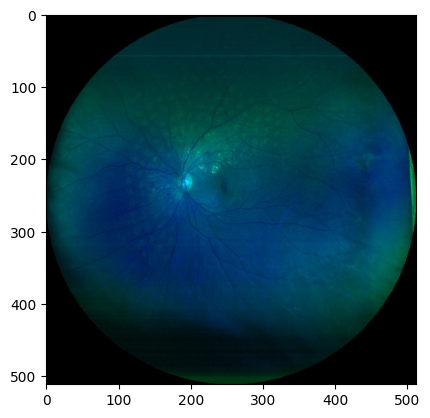

In [115]:
for i in np.random.randint(1, 100, 2):
    print(model.predict(train_dataset[i][0]))
